In [122]:
#https://www.kaggle.com/indralin/try-content-based-and-collaborative-filtering
#https://www.kaggle.com/indralin/movielens-project-1-2-collaborative-filtering
#https://www.kaggle.com/CooperUnion/anime-recommendations-database

In [1]:
import os
datapath = "D:/Datasets/Anime_Dataset"
os.chdir(datapath)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random
import warnings
import re
warnings.filterwarnings("ignore")

In [3]:
anime = pd.read_csv("anime.csv")
ratings = pd.read_csv("rating.csv")

In [4]:
print("Total unique anime : ", len(np.unique(anime['anime_id'])))
print("Total unique users : ", len(np.unique(ratings["user_id"])))

Total unique anime :  12294
Total unique users :  73515


In [5]:
# data cleaning
null_features = anime[anime.isnull().any(1)].columns
anime[null_features].isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [6]:
anime.dropna(inplace = True)

In [7]:
def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    return text

anime['name'] = anime['name'].apply(text_cleaning)

In [8]:
from collections import defaultdict

all_genres = defaultdict(int)

for genres in anime['genre']:
    for genre in genres.split(','):
        all_genres[genre.strip()] += 1

### Content based recommendation system

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

genres_str = anime['genre'].str.split(',').astype(str)

tfidf = TfidfVectorizer(analyzer = 'word',
                        ngram_range = (1,4),
                        min_df = 0)

tfidf_matrix = tfidf.fit_transform(genres_str)

In [11]:
from sklearn.metrics.pairwise import linear_kernel, sigmoid_kernel

lin = linear_kernel(tfidf_matrix, tfidf_matrix)
sig = sigmoid_kernel(tfidf_matrix, tfidf_matrix)

In [12]:
vocabs = {value : key for key, value in tfidf.vocabulary_.items()}

In [13]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray())

In [14]:
tfidf_df.columns = tfidf_df.columns.map(vocabs)

In [15]:
indices = pd.Series(anime.index, index = anime['name'])
indices.head()

name
Kimi no Na wa.                      0
Fullmetal Alchemist: Brotherhood    1
Gintama°                            2
Steins;Gate                         3
Gintama                             4
dtype: int64

In [16]:
def genre_recommendations(title, similarity = False, highest_rating = False):
    
    idx = indices[title]
    
    sim_scores = list(enumerate(lin[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[:11]
    
    anime_indices = [i[0] for i in sim_scores]
    similarity_ = [i[1] for i in sim_scores]
    
    if similarity == False:
        if highest_rating == False:
            return pd.DataFrame({
                "Anime name" : anime['name'].iloc[anime_indices].values,
                "Rating" : anime['rating'].iloc[anime_indices].values,
                'Type' : anime['type'].iloc[anime_indices].values,
            })
        
        if highest_rating == True:
            return pd.DataFrame({
                "Anime name" : anime['name'].iloc[anime_indices].values,
                "Rating" : anime['rating'].iloc[anime_indices].values,
                'Type' : anime['type'].iloc[anime_indices].values,
            }).sort_values(by = ['Rating'], ascending = False)
    
    elif similarity == True:
        if highest_rating == False:
            return pd.DataFrame({
                "Anime name" : anime['name'].iloc[anime_indices].values,
                'Similarity' : similarity_,
                'Type' : anime['type'].iloc[anime_indices].values
            })
        
        elif highest_rating == True:
            return pd.DataFrame({
                "Anime name" : anime['name'].iloc[anime_indices].values,
                'Similarity' : similarity_,
                "Rating" : anime['rating'].iloc[anime_indices].values,
                'Type' : anime['type'].iloc[anime_indices].values
            }).sort_values(by = ['Rating'], ascending = False)

In [17]:
genre_recommendations('Doraemon (1979)', highest_rating = True, similarity = True)

,Anime name,Similarity,Rating,Type
0,Doraemon (1979),1.000000,7.76,TV
6,Doraemon: Obaachan no Omoide,0.924682,7.44,Movie
1,Doraemon Movie 11: Nobita to Animal Planet,1.000000,7.42,Movie
7,Doraemon: Doraemon Comes Back,0.924682,7.39,Special
2,Doraemon Movie 19: Nobita no Nankai Daibouken,1.000000,7.25,Movie
3,Doraemon Movie 16: Nobita no Sousei Nikki,1.000000,7.23,Movie
8,Doraemon: The Day When I Was Born,0.924682,7.15,Movie
9,The☆Doraemons: The Mysterious Thief Dorapan Th...,0.924682,7.04,Movie
4,Dorami and Doraemons: Space Lands Critical Event,1.000000,6.93,Movie
5,The☆Doraemons: Dokidoki Kikansha Daibakusou!,1.000000,6.87,Movie


### collaborative filtering

### simple collaborative filtering / Memory Based collaborative filtering

In [20]:
anime = pd.read_csv("anime.csv")
ratings = pd.read_csv("rating.csv")

In [21]:
data = pd.merge(anime, ratings, on = 'anime_id', suffixes = ['','_user'])

In [22]:
data = data.rename(columns = {'name' : 'anime_title', 'rating_user' : 'user_rating'})
data.head(2)

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10


In [23]:
data.dropna(inplace = True)

In [24]:
import seaborn as sns
# filtering userids which has given more than 2000 reviews
counts = data['user_id'].value_counts()
anime_feature = data[data['user_id'].isin(counts[counts >= 2000].index)].reset_index(drop = True)

In [25]:
anime_pivot = anime_feature.pivot(index = 'anime_title',
                                  columns = 'user_id',
                                  values = 'user_rating').fillna(0)
anime_pivot.head()

user_id,7345,12431,27364,28521,40604,42635,45659,48766,51693,53492,53698,57620,59643,65840,66021
anime_title,,,,,,,,,,,,,,,
&quot;0&quot;,0.0,2.0,0.0,0.0,0.0,5.0,0.0,-1.0,0.0,5.0,5.0,0.0,0.0,0.0,-1.0
"&quot;Aesop&quot; no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu",0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,7.0,5.0,-1.0,7.0,-1.0,6.0,7.0,-1.0,7.0,-1.0,4.0,0.0,7.0,8.0,0.0
&quot;Bungaku Shoujo&quot; Memoire,7.0,7.0,0.0,8.0,-1.0,6.0,9.0,-1.0,7.0,0.0,5.0,0.0,7.0,9.0,-1.0
&quot;Bungaku Shoujo&quot; Movie,7.0,8.0,-1.0,9.0,-1.0,6.0,9.0,-1.0,8.0,0.0,5.0,0.0,7.0,9.0,-1.0


In [26]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

anime_matrix = csr_matrix(anime_pivot.values)
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(anime_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [27]:
anime_index = {value : key for key, value in enumerate(anime_pivot.index)}

In [28]:
query_index = 6572
distances, indices = model_knn.kneighbors(anime_pivot.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 11)


for i in range(0, len(distances.flatten())):
    if i == 0:
        print("Recommendations for {} : \n".format(anime_pivot.index[query_index]))
    else:
        print("{} : {} with distance of {}".format(i, anime_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Nanami-chan 2nd Series : 

1 : Birthday Boy with distance of 1.1102230246251565e-16
2 : Devilman: Tanjou-hen with distance of 1.1102230246251565e-16
3 : Mobile Suit Gundam Unicorn: Episode EX - 100 Years of Solitude with distance of 1.1102230246251565e-16
4 : Nanami-chan 2nd Series with distance of 1.1102230246251565e-16
5 : Gaiking: Legend of Daiku-Maryu with distance of 1.1102230246251565e-16
6 : Mainichi Kaasan with distance of 1.1102230246251565e-16
7 : Monster Extra with distance of 1.1102230246251565e-16
8 : Transformers: Scramble City with distance of 1.1102230246251565e-16
9 : Devilman: Yochou Sirene-hen with distance of 1.1102230246251565e-16
10 : Panda-Z: The Robonimation with distance of 1.1102230246251565e-16


### Model based collaborative filtering

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

In [31]:
anime = pd.read_csv("anime.csv")
ratings = pd.read_csv("rating.csv")

In [32]:
data = pd.merge(anime, ratings, on = 'anime_id', suffixes = ['','_user'])

In [33]:
data = data.rename(columns = {'name' : 'anime_title', 'rating_user' : 'user_rating'})

In [34]:
data['user_rating'].replace({-1 : np.nan}, inplace = True)

In [35]:
data.isnull().sum()

anime_id             0
anime_title          0
genre              110
type                 4
episodes             0
rating               6
members              0
user_id              0
user_rating    1476488
dtype: int64

In [36]:
print(data.shape)
data.dropna(inplace = True)
print(data.shape)
data = data.reset_index(drop = True)

(7813727, 9)
(6337146, 9)


In [37]:
counts = data['user_id'].value_counts()
anime_feature = data[data['user_id'].isin(counts[counts >= 200].index)].reset_index(drop = True)

In [38]:
anime_feature.head(3)

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10.0
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10.0
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,462,8.0


In [39]:
# Exploratory data analysis

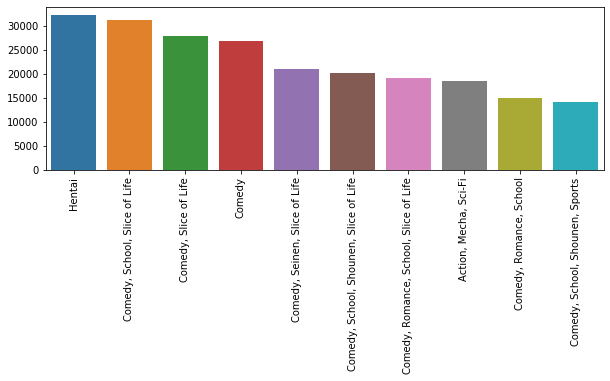

In [40]:
# Top 10 most rated genre
best = anime_feature.groupby(by = ['genre']).aggregate('count').sort_values(by = ['anime_id'], ascending = False).head(10)
plt.figure(figsize = (10, 3))
sns.barplot(best.index.values, best['anime_id'].values)
plt.xticks(rotation = 90)
plt.show()

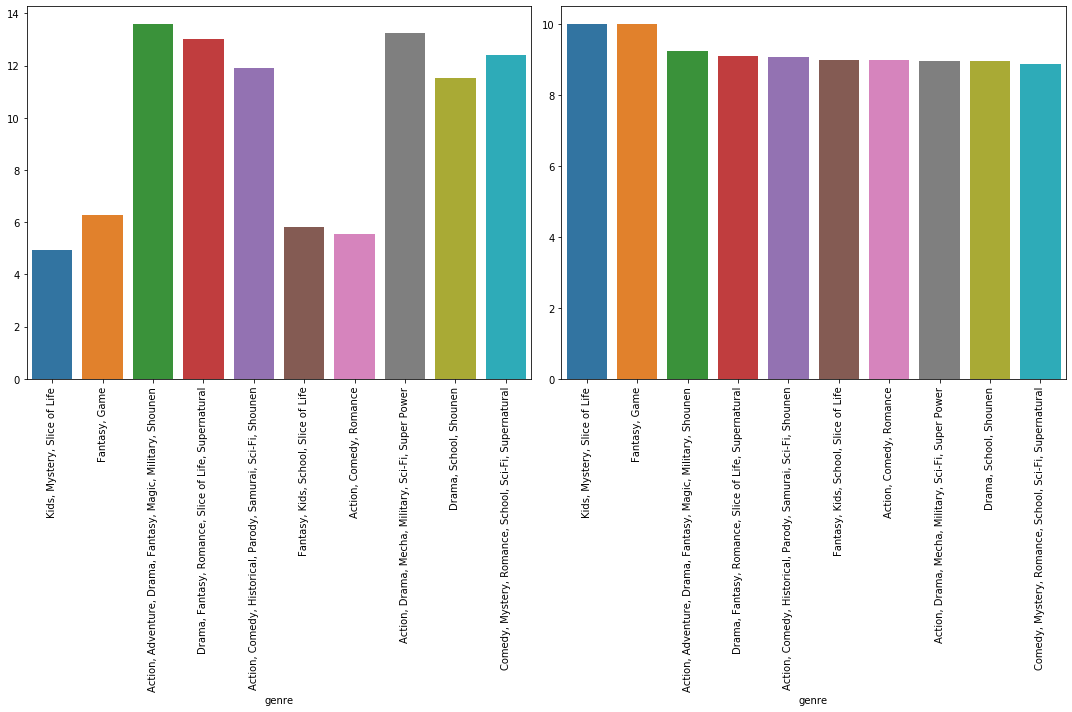

In [41]:
# standings of top 10 genres based on user ratings
best = anime_feature.groupby(by = ['genre']).aggregate('mean').sort_values(by = ['user_rating'], ascending = False)[['members', 'user_rating']].head(10)

#plt.figure(figsize = (15, 5))
##sns.barplot(best.index, best['members'].values)
#sns.barplot(best.index, best['user_rating'].values)
#plt.xticks(rotation = 90)
#plt.show()

fig = plt.figure(figsize = (15, 10))

fig.add_subplot(1,2,1)
sns.barplot(best.index, np.log(best['members'].values))
plt.xticks(rotation = 90)

fig.add_subplot(1,2,2)
sns.barplot(best.index, best['user_rating'].values)
plt.xticks(rotation = 90)

plt.tight_layout()
plt.show()

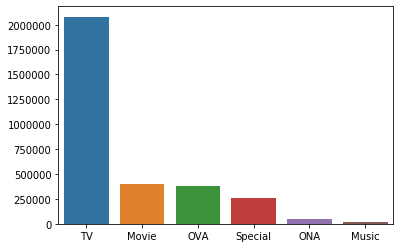

In [42]:
sns.barplot(anime_feature['type'].value_counts().index,
            anime_feature['type'].value_counts().values)

In [43]:
n_users = anime_feature['user_id'].nunique()
n_anime = anime_feature['anime_id'].nunique()

print("# users : ", n_users)
print("# anime : ", n_anime)

# users :  8713
# anime :  9785


In [44]:
anime_feature.head()

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10.0
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10.0
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,462,8.0
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,598,10.0
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,784,9.0


In [45]:
user_anime_matrix = anime_feature.pivot(index = 'user_id',
                                        columns = 'anime_id',
                                        values = 'user_rating').fillna(0)

In [46]:
user_anime_matrix.head()

anime_id,1,5,6,7,8,15,16,17,18,19,...,34238,34239,34240,34252,34283,34324,34325,34349,34367,34475
user_id,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,8.0,0.0,0.0,6.0,0.0,6.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,...,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,10.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
user_ratings_mean = np.mean(user_anime_matrix.values, axis = 1)
anime_ratings_mean = np.mean(user_anime_matrix.values, axis = 0)

In [48]:
user_ratings_demeaned = user_anime_matrix.values - user_ratings_mean.reshape(-1, 1)

In [49]:
sparsity = round((np.sum(user_anime_matrix == 0).sum() / (n_users * n_anime)), 3)
print("Sparsity level : ", sparsity * 100, "%")

Sparsity level :  96.3 %


In [50]:
from scipy.sparse.linalg import svds

# k = no of singular values and vectors to compute
U, sigma, V = svds(user_ratings_demeaned, k = 50)

In [51]:
sigma = np.diag(sigma)

In [52]:
print(U.shape) # user vectors
print(sigma.shape) # sigma vector
print(V.shape) # Anime vectors

(8713, 50)
(50, 50)
(50, 9785)


In [53]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), V) + user_ratings_demeaned

In [54]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = user_anime_matrix.columns)

In [55]:
preds.index = user_anime_matrix.index

In [56]:
preds.head()

anime_id,1,5,6,7,8,15,16,17,18,19,...,34238,34239,34240,34252,34283,34324,34325,34349,34367,34475
user_id,,,,,,,,,,,,,,,,,,,,,
5,1.929948,0.227074,10.342037,-0.559362,0.279735,9.456760,0.771702,7.154207,7.864792,1.919285,...,-0.414067,-0.425489,-0.333756,-0.428058,-0.439508,-0.419297,-0.397033,-0.445034,-0.433524,-0.428303
7,-0.414867,-1.130675,0.320010,-0.585494,-0.463613,-0.071834,-0.177881,-0.249318,-0.478753,0.707096,...,-0.410949,-0.531983,-0.239767,-0.536716,-0.502035,-0.519529,-0.502481,-0.518870,-0.521739,-0.528273
17,5.056434,2.309345,9.743814,-0.939462,-0.880454,-0.300179,-0.979387,-0.728249,-0.398635,13.601374,...,-0.544389,-0.586074,10.261801,-0.582153,-0.565545,-0.587170,-0.595030,-0.593575,-0.581530,-0.585714
38,1.903936,-0.109595,1.317182,-0.259410,-0.619372,-0.069671,-1.753805,-0.489335,-0.054475,1.171413,...,-0.349836,-0.328354,-0.074123,-0.345950,-0.312118,-0.329062,-0.369792,-0.344562,-0.343321,-0.316840
43,13.320004,0.872341,3.385141,0.654086,-0.041195,7.864907,0.007664,-0.353955,-0.694558,0.319339,...,-0.394953,-0.445059,-0.239496,-0.466378,-0.461326,-0.412965,-0.469153,-0.464006,-0.444423,-0.430469


In [57]:
user_id_mapper = {key : value for key, value in enumerate(preds.index.values)}

In [58]:
def recommend_animes(user_id, num_recomms):
    user_row_number = user_id
    sorted_user_predictions = preds.iloc[user_row_number].sort_values(ascending = False)
    
    ratings_data = ratings[ratings['user_id'] == user_id_mapper[user_row_number]]
    ratings_full = ratings_data.merge(anime, on = 'anime_id', suffixes = ["", "_user"]).sort_values(by = ['rating_user'], ascending = False)
    
    print("User {} has already rated {} movies".format(user_id_mapper[user_id], ratings_full.shape[0]))
    
    print("Recommending highest {} predicted ratings anime not already rated".format(num_recomms))
    
    anime_id_recomms = sorted_user_predictions.index[:num_recomms].values
    anime_recomms = anime[anime['anime_id'].isin(anime_id_recomms)]
    
    columns_to_take = ['name', 'genre', 'type', 'episodes', 'rating']
    
    return ratings_full[columns_to_take].head(10), anime_recomms[columns_to_take]

In [59]:
rated, unrated = recommend_animes(3, 10)

User 38 has already rated 253 movies
Recommending highest 10 predicted ratings anime not already rated


In [60]:
rated

,name,genre,type,episodes,rating
61,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,10
251,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,10
120,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,10
48,Clannad: After Story,"Drama, Fantasy, Romance, Slice of Life, Supern...",TV,24,3
18,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,201,7
37,Code Geass: Hangyaku no Lelouch R2,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",TV,25,10
230,Haikyuu!! Second Season,"Comedy, Drama, School, Shounen, Sports",TV,25,10
22,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,10
234,One Punch Man,"Action, Comedy, Parody, Sci-Fi, Seinen, Super ...",TV,12,9
27,Tengen Toppa Gurren Lagann,"Action, Adventure, Comedy, Mecha, Sci-Fi",TV,27,10


In [61]:
unrated

,name,genre,type,episodes,rating
1,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26
13,Code Geass: Hangyaku no Lelouch R2,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",TV,25,8.98
19,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83
86,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54
94,Fate/Zero,"Action, Fantasy, Supernatural",TV,13,8.51
98,Psycho-Pass,"Action, Police, Psychological, Sci-Fi",TV,22,8.50
118,No Game No Life,"Adventure, Comedy, Ecchi, Fantasy, Game, Super...",TV,12,8.47
740,Toaru Kagaku no Railgun,"Action, Sci-Fi, Super Power",TV,24,7.87
789,Toaru Majutsu no Index II,"Action, Magic, Sci-Fi, Super Power",TV,24,7.84
1096,Toaru Majutsu no Index,"Action, Magic, Sci-Fi, Super Power",TV,24,7.69


### Collaborative filtering using Surprise Library

In [63]:
from surprise import Reader, Dataset, SVD, SVDpp
from surprise import accuracy

In [80]:
rating = pd.read_csv("rating.csv")
anime = pd.read_csv("anime.csv")

In [81]:
data = pd.merge(anime, rating, on = 'anime_id', suffixes = ["", "_user"])

In [82]:
data = data.rename(columns = {"name" : "anime_title", "rating_user" : "user_rating"})

In [83]:
data['user_rating'].replace({-1 : np.nan}, inplace = True)

In [84]:
data.dropna(inplace = True)

In [85]:
data.shape

(6337146, 9)

In [86]:
counts = data['user_id'].value_counts()
data = data[data['user_id'].isin(counts[counts >= 1000].index)].reset_index(drop = True)

In [87]:
print("# users : ", data["user_id"].nunique())
print("# anime : ", data["anime_id"].nunique())

# users :  165
# anime :  9186


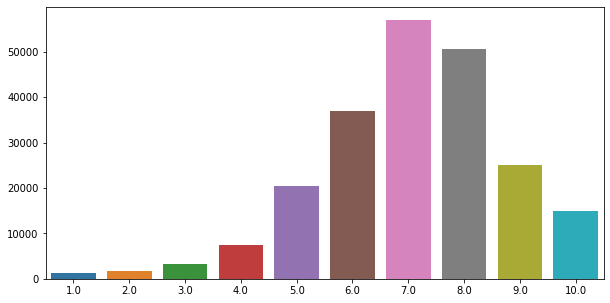

In [88]:
plt.figure(figsize = (10, 5))
sns.barplot(data['user_rating'].value_counts().index,
            data['user_rating'].value_counts().values)
plt.show()

In [89]:
data[["user_id", "anime_id", "user_rating"]]

,user_id,anime_id,user_rating
0,1497,32281,10.0
1,2951,32281,9.0
2,6569,32281,10.0
3,7249,32281,10.0
4,10826,32281,10.0
...,...,...,...
218713,58483,5541,1.0
218714,58483,9316,1.0
218715,49503,5543,4.0
218716,58483,5543,1.0


In [90]:
from surprise import Reader, Dataset, SVD, SVDpp
from surprise import accuracy

In [91]:
reader = Reader(rating_scale = (1, 10))

dataset = Dataset.load_from_df(data[["user_id", "anime_id", "user_rating"]], reader = reader)

In [92]:
svd = SVD(n_factors = 50)

In [93]:
svd_plusplus = SVDpp(n_factors = 50)

In [95]:
trainset = dataset.build_full_trainset()

In [96]:
svd.fit(trainset)

In [98]:
#svd_plusplus.fit(trainset)

In [100]:
id_2_names = dict()

for idx, names in zip(anime['anime_id'], anime['name']):
    id_2_names[idx] = names

In [105]:
def build_anti_testset4user(user_id):
    
    fill = trainset.global_mean
    anti_testset = list()
    u = trainset.to_inner_uid(user_id)
    
    # ur == user ratings
    user_items = set([item_inner_id for (item_inner_id, rating) in trainset.ur[u]])
    
    anti_testset += [(trainset.to_raw_uid(u), trainset.to_raw_iid(i), fill) for i in trainset.all_items() if i not in user_items]
    
    return anti_testset

In [110]:
def Top_n_Recs_SVD(user_id, num_recommender = 10):
    testSet = build_anti_testset4user(user_id)
    predict = svd.test(testSet)
    
    recommendation = list()
    
    for userID, animeID, actualRating, estimatedRating, _ in predict:
        intAnimeID = int(animeID)
        recommendation.append((intAnimeID, estimatedRating))
    
    recommendation.sort(key = lambda x : x[1], reverse = True)
    
    anime_names = []
    anime_ratings = []
    
    for name, ratings in recommendation[:20]:
        anime_names.append(id_2_names[name])
        anime_ratings.append(ratings)
        
    anime_dataframe = pd.DataFrame({"name" : anime_names,
                                    "rating" : anime_ratings}).merge(anime[['name', 'type', 'episodes']], on = 'name', how = 'left')
    
    return anime_dataframe.head(num_recommender)

In [111]:
Top_n_Recs_SVD(1497)

,name,rating,type,episodes
0,Fullmetal Alchemist: Brotherhood,10.000000,TV,64
1,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,9.786257,TV,10
2,Gosick,9.745759,TV,24
3,Mawaru Penguindrum,9.353662,TV,24
4,Hunter x Hunter (2011),9.340271,TV,148
5,Lovely★Complex,9.331919,TV,24
6,Kara no Kyoukai 7: Satsujin Kousatsu (Kou),9.212033,Movie,1
7,Nurarihyon no Mago: Sennen Makyou,9.186290,TV,24
8,Monster,9.158537,TV,74
9,Kemono no Souja Erin,9.152177,TV,50


In [112]:
testset = trainset.build_anti_testset()
predictions_svd = svd.test(testset)

In [113]:
print("SVD - RMSE : ", accuracy.rmse(predictions_svd, verbose = False))
print("SVD - MAE : ", accuracy.mae(predictions_svd, verbose = False))

SVD - RMSE :  1.2280538430459815
SVD - MAE :  0.9459308043536823


In [114]:
## function to give a recommendation to all users

In [115]:
from collections import defaultdict

def GetTopN(predictions, n = 10, minimum_rating = 6):
    topN = defaultdict(list)
    
    for userID, animeID, actualRating, estimatedRating, _ in predictions:
        if estimatedRating >= minimum_rating:
            topN[int(userID)].append((int(animeID), estimatedRating))
    
    for userID, ratings in topN.items():
        ratings.sort(key = lambda x : x[1], reverse = True)
        topN[int(userID)] = ratings[:n]
    
    return topN

In [120]:
top_n = GetTopN(predictions_svd, n = 10)
    
ii = 0
for uid, predict_ratings in top_n.items():
    print(uid, [iid for (iid, _) in predict_ratings])
    ii += 1
        
    if ii > 5:
        break

1497 [5114, 32935, 8425, 10721, 11061, 2034, 5205, 10049, 19, 5420]
2951 [11887, 13601, 7711, 801, 10153, 6675, 27821, 12477, 330, 20]
6569 [19, 820, 1698, 44, 918, 11061, 578, 2164, 1033, 28977]
7249 [1974, 457, 12431, 2246, 5114, 21939, 33, 1453, 28977, 13125]
10826 [11061, 2581, 1974, 3588, 6, 416, 3701, 1594, 28805, 3927]
13877 [28701, 15689, 11737, 2025, 16512, 881, 4081, 16035, 159, 9330]
